In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_kddcup99
%matplotlib inline

In [2]:
dataset = fetch_kddcup99(subset=None, shuffle=True, percent10=True)
# http://www.kdd.org/kdd-cup/view/kdd-cup-1999/Tasks
X = dataset.data
y = dataset.target

In [3]:
X = pd.DataFrame(X, columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serrer_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'])

In [4]:
y = pd.Series(y)

In [5]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,255,1,0,1,0,0,0,0,0
1,0,tcp,http,SF,260,892,0,0,0,0,...,255,255,1,0,0,0,0,0,0,0
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,255,1,0,1,0,0,0,0,0
3,0,tcp,smtp,SF,1164,403,0,0,0,0,...,68,173,0.84,0.04,0.01,0.01,0,0,0,0
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,255,1,0,1,0,0,0,0,0


In [6]:
for col in X.columns:  # turn whatever columns into floats that we can
    try:
        X[col] = X[col].astype(float)
    except ValueError:
        pass

In [7]:
X = pd.get_dummies(X, prefix=['protocol_type_', 'service_', 'flag_'], drop_first=True)

In [8]:
X.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,260.0,892.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,1164.0,403.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
y.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
dtype: int64

In [10]:
under_represented_attacks = [a for a in y.unique() if a not in ['smurf.', 'neptune.', 'normal.']]
under_represented_attacks

['portsweep.',
 'back.',
 'satan.',
 'ipsweep.',
 'warezclient.',
 'pod.',
 'nmap.',
 'teardrop.',
 'guess_passwd.',
 'ftp_write.',
 'rootkit.',
 'buffer_overflow.',
 'multihop.',
 'phf.',
 'land.',
 'warezmaster.',
 'imap.',
 'loadmodule.',
 'perl.',
 'spy.']

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [13]:
sgdclf = SGDClassifier()
scores = cross_val_score(sgdclf, X, y, scoring='accuracy', cv=5)

/Users/ronliu/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [15]:
scores.mean()

0.75101861327061847

In [16]:
# How about a Random Forest?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

scores = cross_val_score(rf, X, y, scoring='accuracy', cv=5)

np.mean(scores)  # nicer

0.99972470760316445

In [17]:
from sklearn.pipeline import Pipeline  # now with some dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pipe = Pipeline(steps=[('pca', pca), ('model', rf)])


In [18]:
scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=5)

np.mean(scores)   # basically just as good

0.99925307058797519

In [19]:
rf.fit(X, y)  # looking at some of the important features

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [20]:
pd.DataFrame({'feature':X.columns, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False).head(10)
# look at feature importances

,feature,importance
20,srv_count,0.166627
19,count,0.133648
1,src_bytes,0.098701
32,dst_host_same_src_port_rate,0.092159
35,dst_host_srv_serror_rate,0.061164
38,protocol_type__tcp,0.052242
31,dst_host_diff_srv_rate,0.051483
26,diff_srv_rate,0.048739
113,flag__SF,0.044644
39,protocol_type__udp,0.039731


In [21]:
X['service__ecr_i'].describe()

count    494021.000000
mean          0.569611
std           0.495131
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: service__ecr_i, dtype: float64

In [22]:
X['land'].describe()

count    494021.000000
mean          0.000045
std           0.006673
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: land, dtype: float64

## Anomoly Detection

“An outlier is an observation in a data set which appears to be inconsistent with the remainder of that set of data.”

* Supervised Anomoly Detection
    * Labels available for both normal data and anomalies
    * Similar to rare class mining / imbalanced classification

* Unsupervised Anomoly Detection (Outlier Detection)
    * no labels, training set = normal + abnormal data • Assumption: anomalies are very rare

* Semi-supervised Anomoly Detection (Novelty Detection)
    * Only normal data available to train
    * The algorithm learns on normal data only

Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.


![](http://scikit-learn.org/stable/_images/sphx_glr_plot_isolation_forest_001.png)

In [32]:
# Supervised and Outlier Detection with KDD

# In this example, we will want to use binary data where 1 will represent a "not-normal" attack

In [23]:
from sklearn.model_selection import train_test_split

y_binary = y != 'normal.'



In [24]:
y_binary.head()

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary)

In [26]:
y_test.value_counts(normalize=True)  # check our null accuracy

True     0.804512
False    0.195488
dtype: float64

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)  # make a single test train split


In [28]:
from sklearn.ensemble import IsolationForest

model = IsolationForest()
model.fit(X_train)  # notice that there is no y in the .fit

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [29]:
y_predicted = model.predict(X_test)

In [30]:
pd.Series(y_predicted).value_counts()

 1    111057
-1     12449
dtype: int64

In [31]:
y_predicted = np.where(y_predicted==1, 1, 0)  # turn into 0s and 1s

In [32]:
pd.Series(y_predicted).value_counts()  # that's better

1    111057
0     12449
dtype: int64

In [33]:
scores = model.decision_function(X_test)

In [34]:
scores  # the smaller, the more anomolous

array([ 0.05708562,  0.16886509,  0.16886509, ..., -0.03403261,
        0.06319217,  0.16886509])

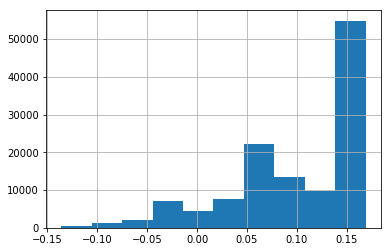

In [35]:
pd.Series(scores).hist()

In [36]:
from sklearn.metrics import accuracy_score
preds = np.where(scores < 0, 0, 1)  # customize threshold
accuracy_score(preds, y_test)

0.0

In [37]:
for t in (-2, -.15, -.1, -.05, 0, .05):
    preds = np.where(scores < t, 0, 1)  # customize threshold
    print t, accuracy_score(preds, y_test)

-2 0.0
-0.15 0.0
-0.1 0.0
-0.05 0.0
0 0.0
0.05 0.0


In [ ]:
## -0.05 0.816988648325 gives us better than the null accuracy, without ever needing the testing set
# This shows how we can can achieve predictive results without labeled data

In [ ]:
# This is an interesting use case of novelty detection becuase generally, when given labels
# we do not use such tactics.

In [38]:
y_test.head()

83864     normal.
361511     smurf.
31221      smurf.
420476     smurf.
428825     smurf.
dtype: object